# EDA and Modeling of Heart Disease Dataset
source of dataset: https://archive.ics.uci.edu/ml/datasets/heart+disease
This dataset has 76 attributes of which only 14 considered in this analysis.
Here we try to predict the possibility of heart disease using different predictive machine learning models existed in scikit-learn.

## Import data and modules

In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, f1_score
from sklearn.metrics import plot_roc_curve, plot_precision_recall_curve

from warnings import filterwarnings
filterwarnings("ignore")

In [5]:
df = pd.read_csv("heart-disease.csv")
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


### Column description
* age: age in years
* sex: sex (1 = male; 0 = female
* cp: chest pain type
-- Value 1: typical angina
-- Value 2: atypical angina
-- Value 3: non-anginal pain
-- Value 4: asymptomatic
* trestbps: resting blood pressure (in mm Hg on admission to the hospital)
* chol: serum cholestoral in mg/dl
* fbs: (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
* restecg: resting electrocardiographic results
-- Value 0: normal
-- Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
-- Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria
* thalach: maximum heart rate achieved
* exang: exercise induced angina (1 = yes; 0 = no)
* oldpeak = ST depression induced by exercise relative to rest
* slope: the slope of the peak exercise ST segment
-- Value 1: upsloping
-- Value 2: flat
-- Value 3: downsloping
* ca: number of major vessels (0-3) colored by flourosopy
* thal: 3 = normal; 6 = fixed defect; 7 = reversable defect
* num: diagnosis of heart disease (angiographic disease status)
-- Value 0: < 50% diameter narrowing
-- Value 1: > 50% diameter narrowing
(in any major vessel: attributes 59 through 68 are vessels)

## Exploratory Data Analysis

In [23]:
# This is a clean dataset with no missing data
df.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [21]:
# This is a pretty balanced dataset
df.target.value_counts()

1    165
0    138
Name: target, dtype: int64

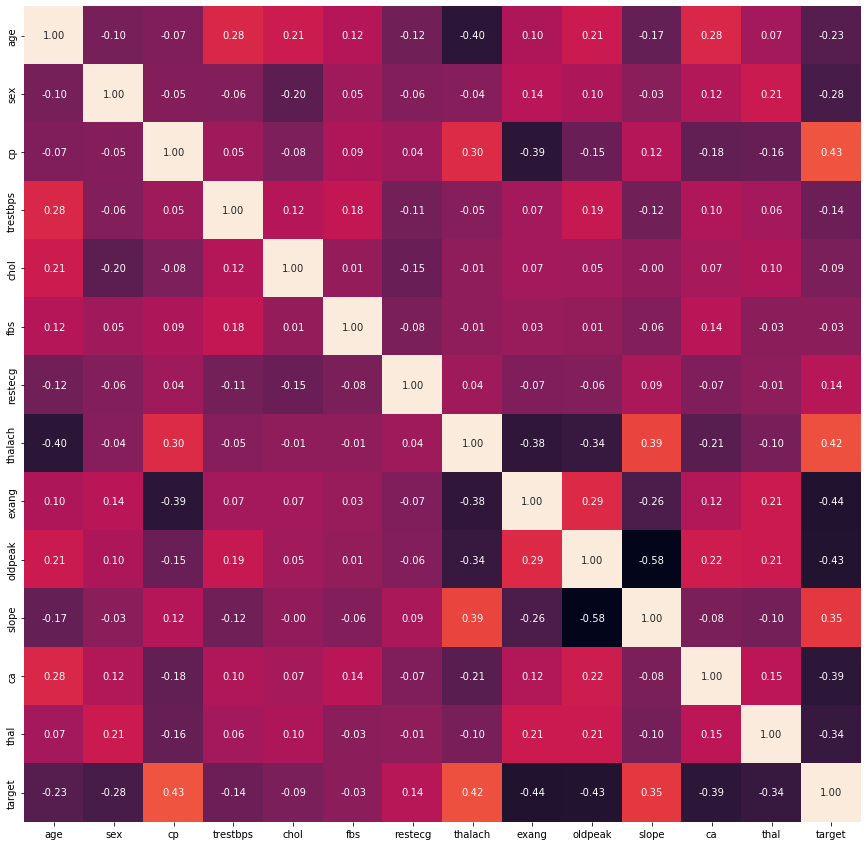

In [13]:
correlation = df.corr()
fig, ax = plt.subplots(figsize=(15,15))
ax = sns.heatmap(correlation, annot=True, fmt=".2f", cbar=False)

In [25]:
pd.crosstab(df.sex, df.target)

target,0,1
sex,,
0,24,72
1,114,93


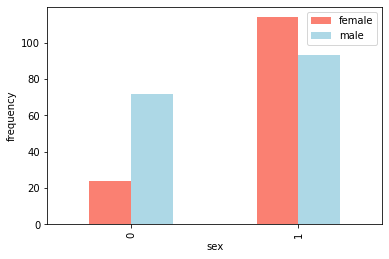

In [35]:
pd.crosstab(df.sex, df.target).plot.bar(color=["salmon", "lightblue"])
plt.legend(["female", "male"])
plt.ylabel("frequency");

In [36]:
pd.crosstab(df.cp, df.target)

target,0,1
cp,,
0,104,39
1,9,41
2,18,69
3,7,16


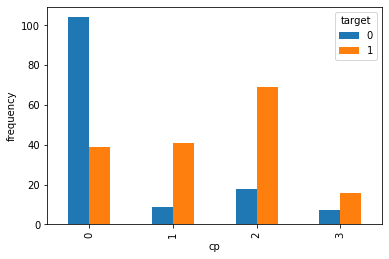

In [38]:
# type of chest pain vs frequency
pd.crosstab(df.cp, df.target).plot.bar()
plt.ylabel("frequency");

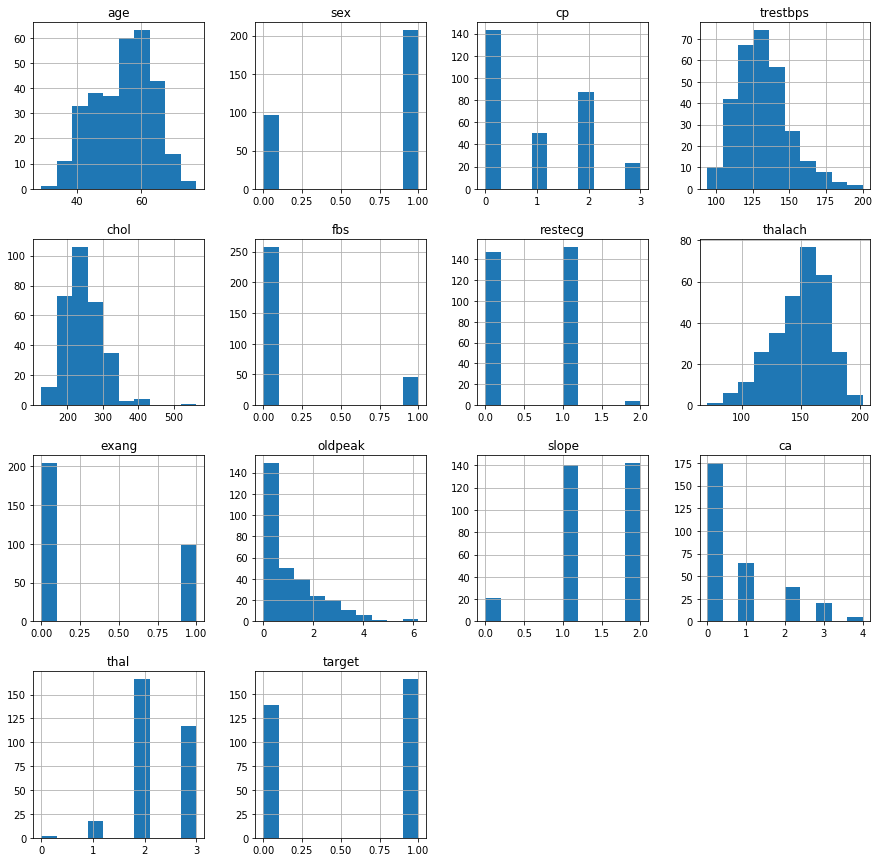

In [44]:
# histograms of columns
df.hist(figsize=(15,15));

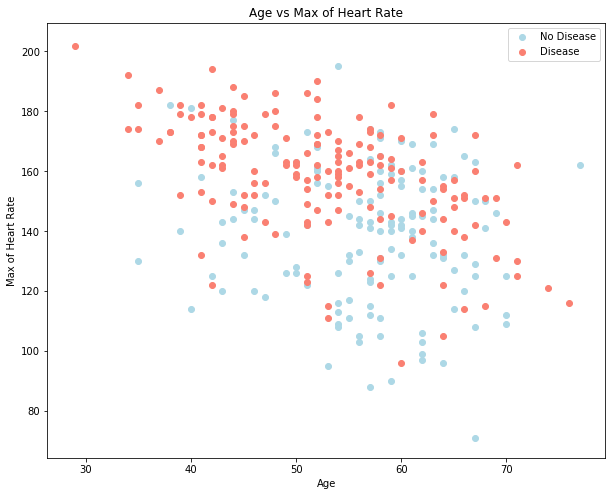

In [145]:
plt.figure(figsize=(10,8))

plt.scatter(df.age[df.target==0], df.thalach[df.target==0], c='lightblue')

plt.scatter(df.age[df.target==1], df.thalach[df.target==1], c='salmon')

plt.title('Age vs Max of Heart Rate')
plt.xlabel('Age')
plt.ylabel('Max of Heart Rate')
plt.legend(['No Disease', 'Disease']);

## Modeling

In [71]:
np.random.seed(0)

# split data into training and test datasets
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,:-1].values, df.iloc[:,-1].values)

# scaling
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [72]:
# fucntion to calculate the scoring of preliminary classifiers
models_dic = {"logrec":LogisticRegression(),
            "svm": LinearSVC(),
            "knn": KNeighborsClassifier(),
            "rf": RandomForestClassifier()}
def choose_cls(model_dic, X_train, X_test, y_train, y_test):
    
    model_scores = {}
    
    for key, model in model_dic.items():
        model.fit(X_train, y_train)
        model_scores[key] = model.score(X_test, y_test)
        
    return model_scores   

In [73]:
choose_cls(model_dic=models_dic, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)

{'logrec': 0.8947368421052632,
 'svm': 0.868421052631579,
 'knn': 0.8157894736842105,
 'rf': 0.868421052631579}

In [104]:
# Grid search for each three of the above models: logrec, svm, rf

models_dic = {"logrec":LogisticRegression(solver='liblinear'),
            "svm": LinearSVC(dual=False),
            "rf": RandomForestClassifier()}

model_param_dic = {"logrec": {'clf__C': np.logspace(-4,4,9), 
                             'clf__penalty':['l1', 'l2']},
                   "svm": {'clf__C': np.logspace(-4,4,9),
                          'clf__penalty': ['l1', 'l2']},
                   "rf": {'clf__n_estimators': np.arange(10,100,10),
                          'clf__max_depth': np.arange(5,25,5)}}
X = df.iloc[:,:-1].values
y = df.iloc[:,-1].values

def rand_search(models_dic, model_param_dic, X, y):
    
    model_best_scores = {}
    model_best_params = {}
    
    for key, model in models_dic.items():
        pipeline = Pipeline([
            ('scaler', MinMaxScaler()),
            ('clf', model)
            ])
        gcv = GridSearchCV(pipeline, param_grid=model_param_dic[key])
        gcv.fit(X, y)
        model_best_scores[model] = gcv.best_score_
        model_best_params[model] = gcv.best_params_
        
    return model_best_params, model_best_scores

In [105]:
rand_search(models_dic=models_dic, model_param_dic=model_param_dic, X=X, y=y)

({LogisticRegression(solver='liblinear'): {'clf__C': 10.0,
   'clf__penalty': 'l2'},
  LinearSVC(dual=False): {'clf__C': 100.0, 'clf__penalty': 'l1'},
  RandomForestClassifier(): {'clf__max_depth': 5, 'clf__n_estimators': 30}},
 {LogisticRegression(solver='liblinear'): 0.831584699453552,
  LinearSVC(dual=False): 0.8283060109289618,
  RandomForestClassifier(): 0.8380327868852457})

## Using LogistricRegression as our best estimator for the rest of analysis

In [108]:
clf = LogisticRegression()
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.8947368421052632

In [109]:
y_pred = clf.predict(X_test)

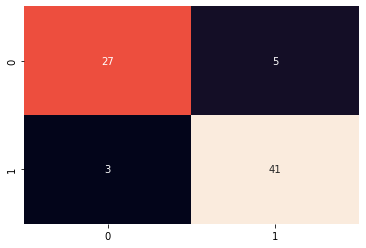

In [113]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cbar=False);

In [114]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.84      0.87        32
           1       0.89      0.93      0.91        44

    accuracy                           0.89        76
   macro avg       0.90      0.89      0.89        76
weighted avg       0.89      0.89      0.89        76



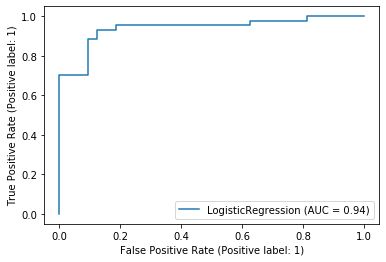

In [118]:
plot_roc_curve(clf, X_test, y_test);

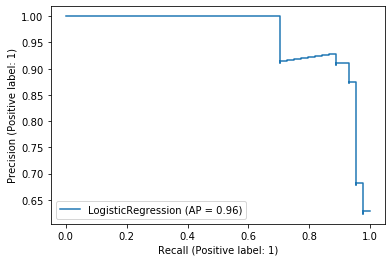

In [120]:
plot_precision_recall_curve(clf, X_test, y_test);

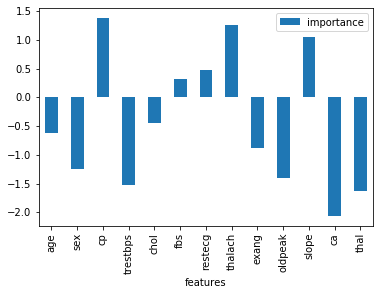

In [139]:
# Show feature importance for the logesticregression model
feature_importance = pd.DataFrame({'features': list(df.columns[:-1]), 
                                   'importance': clf.coef_[0] })
ax = feature_importance.plot.bar()
ax.set_xlabel('features')
ax.set_xticklabels(list(df.columns[:-1]));